In [7]:
import numpy as np
import numpy.polynomial.polynomial as pol
import numpy.linalg as la
import matplotlib.pyplot as plt
%matplotlib notebook

import pattrex.plotting_mpl as plt_rex
import pattrex.preprocessing as pre_rex

In [5]:
dt = np.dtype([('w', np.float), ('h', np.float), ('g', 'S1')])  # g is byte-string

data = np.loadtxt('data/whData.dat', dtype=dt, comments='#', delimiter=None)

ws = np.array([d[0] for d in data])
hs = np.array([d[1] for d in data])
gs = np.array([d[2].decode('utf-8') for d in data])

HWG = np.vstack((hs, ws, gs))  # data is going to be column-wise
# X.transpose()  # this will make it row-wise
HWG.shape

(3, 24)

In [6]:
# remove outliers and save their indices
HW_new, neg_idx = pre_rex.only_all_positive(HWG[0:2, :].astype(np.float), True, 
                                  return_neg_idx = True)

print(neg_idx)

[ 7 12 20]


## Now we have data without the outliers

In [13]:
x = HW_new[0, :]  # Height
Y = HW_new[1, :]  # Weight

[ 186.  170.  167.  173.  186.  180.  173.  174.  170.  186.  175.  162.
  174.  178.  178.  174.  168.  160.  174.  175.  162.]


### First we use `numpy.linalg`

In [48]:
d = 5

X = pol.polyvander(x, d)

W = la.lstsq(X, Y)[0]  # discard other information

<IPython.core.display.Javascript object>


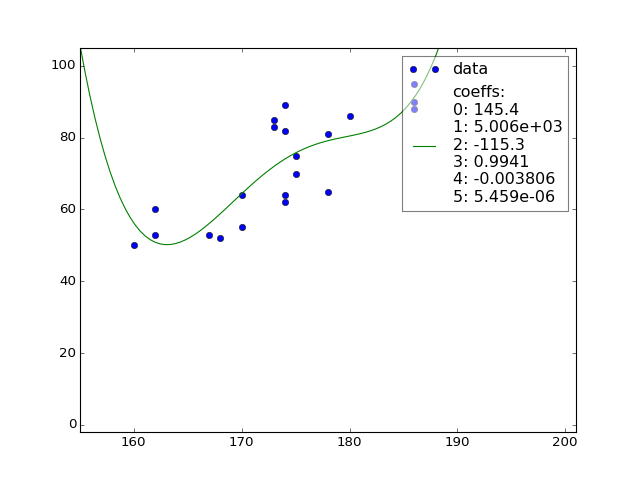

In [49]:
fig = plt.figure()
axs = fig.add_subplot(111)

# limits for the axes
HW_ = np.vstack((hs, ws))  # only the measurements; data is col-wise
xmin, ymin = HW_.min(axis=1)
xmax, ymax = HW_.max(axis=1)

xlim = [xmin-5, xmax+15]  # purely for looks
ylim = [-2, ymax+10]

# generate data for the fitted solution
h = np.linspace(xlim[0], xlim[1], 100)
h_ = pol.polyvander(h, d)
w = np.dot(h_, W)

plt_rex.plot2d(HW_new, colwise_data=True, hatch='bo', x_lim=xlim, y_lim=ylim, 
               show=False, axs=axs, plotlabel="data")

plt_label = "coeffs:\n" + "\n".join("{}: {:.4}".format(*c) for c in enumerate(W))
plt_rex.plot2d(np.vstack((h, w)), colwise_data=True, hatch='g', 
               show=False, axs=axs, plotlabel=plt_label)


In [50]:
plt.close('all')

### Let us try our own solution

In [46]:
def lstsq_rex(X, Y):
    XtX_inv = la.pinv(X)
    return np.dot(XtX_inv, Y)
    

In [51]:
lstsq_rex(X, Y)

array([  1.45372950e+02,   5.00648642e+03,  -1.15279840e+02,
         9.94128981e-01,  -3.80603682e-03,   5.45891545e-06])

## Predicting weights for outliers

In [64]:
h_ol = np.array([h for i, h in enumerate(hs) if i in neg_idx])
h_ol


array([ 168.,  172.,  167.])

In [66]:
h_ol_ = pol.polyvander(h_ol, d)
w_pred = np.dot(h_ol_, W)
w_pred

array([ 58.79472704,  69.71529775,  56.14154704])

<IPython.core.display.Javascript object>


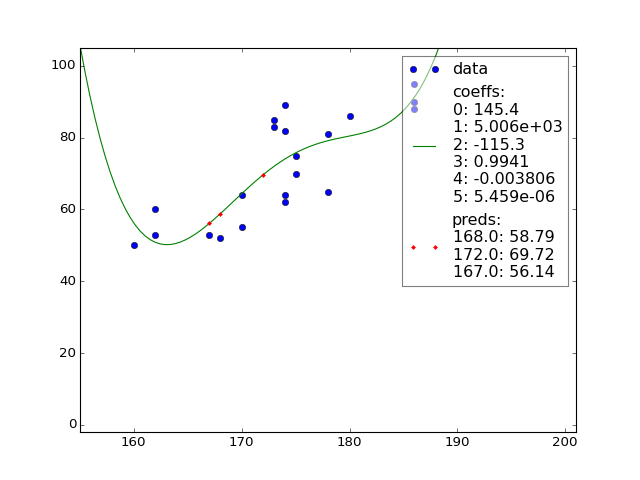

In [69]:
fig = plt.figure()
axs = fig.add_subplot(111)

# limits for the axes
HW_ = np.vstack((hs, ws))  # only the measurements; data is col-wise
xmin, ymin = HW_.min(axis=1)
xmax, ymax = HW_.max(axis=1)

xlim = [xmin-5, xmax+15]  # purely for looks
ylim = [-2, ymax+10]

# generate data for the fitted solution
h = np.linspace(xlim[0], xlim[1], 100)
h_ = pol.polyvander(h, d)
w = np.dot(h_, W)

plt_rex.plot2d(HW_new, colwise_data=True, hatch='bo', x_lim=xlim, y_lim=ylim, 
               show=False, axs=axs, plotlabel="data")

plt_label = "coeffs:\n" + "\n".join("{}: {:.4}".format(*c) for c in enumerate(W))
plt_rex.plot2d(np.vstack((h, w)), colwise_data=True, hatch='g', 
               show=False, axs=axs, plotlabel=plt_label)

plt_label = "preds:\n" + "\n".join("{}: {:.4}".format(*c) for c in zip(h_ol, w_pred))
plt_rex.plot2d(np.vstack((h_ol, w_pred)), colwise_data=True, hatch='r.', 
               show=False, axs=axs, plotlabel=plt_label)